# <span style="color: blue;">ให้กรอกรหัสนิสิต และชื่อ-นามสกุลของสมาชิกในทีม</span>
# <span style="color: blue;">(ห้ามมีสมาชิกเกิน 2 คน)</span>
## รหัสนิสิต ชื่อ-นามสกุล
<span style="color: green;">6714450249 นายหรินทร์ ธนะนาม</span>

## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## Pima Diabetes Dataset

* Kaggle Dataset (https://www.kaggle.com/datasets/kumargh/pimaindiansdiabetescsv)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [87]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [88]:
## Import Keras objects for Deep Learning

from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [89]:
## Load in the data set (Internet Access needed)
# Download pima-indians-diabetes.csv from https://www.kaggle.com/datasets/kumargh/pimaindiansdiabetescsv

seed_value = 11111
url = "pima-indians-diabetes.csv"
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", 
         "skin_thickness", "insulin", "bmi", "pedigree_function", 
         "age", "has_diabetes"]
diabetes_df = pd.read_csv(url, names=names)

In [90]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
405,2,123,48,32,165,42.1,0.520,26,0
231,6,134,80,37,370,46.2,0.238,46,1
406,4,115,72,0,0,28.9,0.376,46,1
717,10,94,72,18,0,23.1,0.595,56,0
653,2,120,54,0,0,26.8,0.455,27,0


In [91]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [92]:
# Split the data to Train, and Test (75%, 25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed_value, stratify=y)

In [93]:
np.mean(y), np.mean(1-y)

(np.float64(0.3489583333333333), np.float64(0.6510416666666666))

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [94]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200, random_state=seed_value)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=11111)

In [95]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

print('accuracy is {:.3f}, roc-auc is {:.3f}'.format(
    accuracy_score(y_test, y_pred_class_rf), roc_auc_score(y_test, y_pred_prob_rf[:,1])))

accuracy is 0.771, roc-auc is 0.795


#### Let's fit our model for 100 epochs.

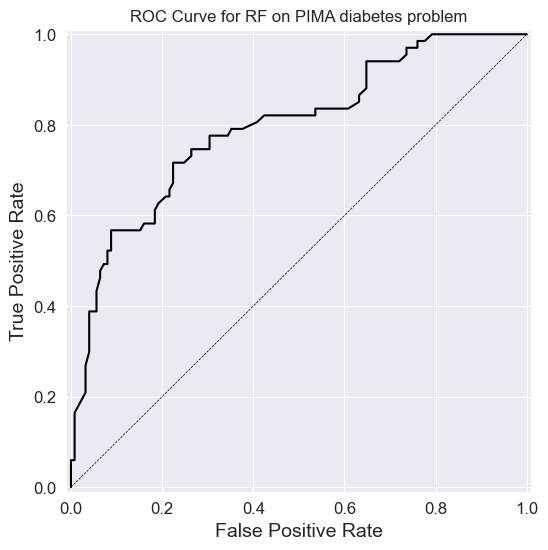

In [96]:
def plot_roc(y_test, y_pred, model_name):
    plt.close('all')

    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
    ax.tick_params(axis='both', which='major', labelsize=12)  
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.show()

plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 8 nodes.

In [97]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [98]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 8 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

import os, random, numpy as np
import tensorflow as tf 

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

model_1 = Sequential([
    Dense(8, input_shape=(8, ), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [99]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81 (324.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)

In [100]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(optimizer=SGD(learning_rate=0.003), loss="binary_crossentropy", metrics=["accuracy"])

run_hist_1 = model_1.fit(X_train_norm, y_train, validation_split=0.1, epochs=100, batch_size=32)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4474 - loss: 0.7842 - val_accuracy: 0.4138 - val_loss: 0.7636
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4533 - loss: 0.7768 - val_accuracy: 0.4655 - val_loss: 0.7551
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4665 - loss: 0.7699 - val_accuracy: 0.4828 - val_loss: 0.7471
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4802 - loss: 0.7632 - val_accuracy: 0.4828 - val_loss: 0.7395
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4851 - loss: 0.7569 - val_accuracy: 0.4828 - val_loss: 0.7323
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4979 - loss: 0.7509 - val_accuracy: 0.5000 - val_loss: 0.7254
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5155 - loss: 0.7452 - val_accuracy: 0.5345 - val_loss: 0.7189
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5258 - loss: 0.7398 - val_accuracy: 0.5517 - 

In [101]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score. so this time we'll define as 0.5

y_pred_prob_nn_1 = model_1.predict(X_test_norm)
y_pred_class_nn_1 = (y_pred_prob_nn_1 >= 0.5).astype('int32')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [102]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_prob_nn_1[:10]

array([[0.48106936],
       [0.276705  ],
       [0.36942595],
       [0.2271858 ],
       [0.555322  ],
       [0.4941245 ],
       [0.46497065],
       [0.24609938],
       [0.2942855 ],
       [0.7480912 ]], dtype=float32)

In [103]:
y_pred_class_nn_1[:10]

array([[0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1]], dtype=int32)

accuracy is 0.703, roc-auc is 0.806


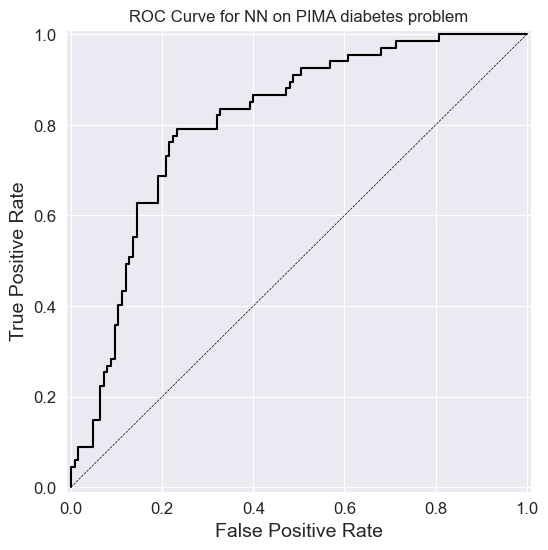

In [104]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}, roc-auc is {:.3f}'.format(
    accuracy_score(y_test, y_pred_class_nn_1),
    roc_auc_score(y_test, y_pred_prob_nn_1))
)

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [105]:
run_hist_1.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

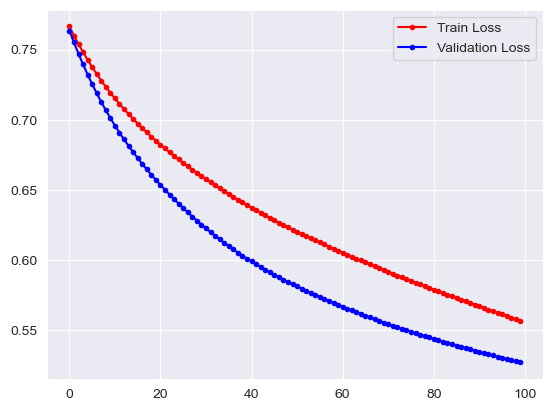

In [124]:
plt.close('all')
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()
plt.show()

Looks like the losses are still going down on both the training set and the validation set.
This suggests that the model might benefit from further training.

Let's train the model a little more and see what happens.
Note that it will pick up from where it left off. Train for 400 more epochs.

In [107]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_split=0.1, epochs=400, batch_size=32)

Epoch 1/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7635 - loss: 0.5345 - val_accuracy: 0.7931 - val_loss: 0.5262
Epoch 2/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7672 - loss: 0.5331 - val_accuracy: 0.7931 - val_loss: 0.5255
Epoch 3/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7672 - loss: 0.5318 - val_accuracy: 0.7931 - val_loss: 0.5247
Epoch 4/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7672 - loss: 0.5305 - val_accuracy: 0.7931 - val_loss: 0.5240
Epoch 5/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7667 - loss: 0.5292 - val_accuracy: 0.7931 - val_loss: 0.5233
Epoch 6/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7672 - loss: 0.5279 - val_accuracy: 0.7931 - val_loss: 0.5225
Epoch 7/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7669 - loss: 0.5267 - val_accuracy: 0.7931 - val_loss: 0.5219
Epoch 8/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7737 - loss: 0.5254 - val_accuracy: 0.7931 - v

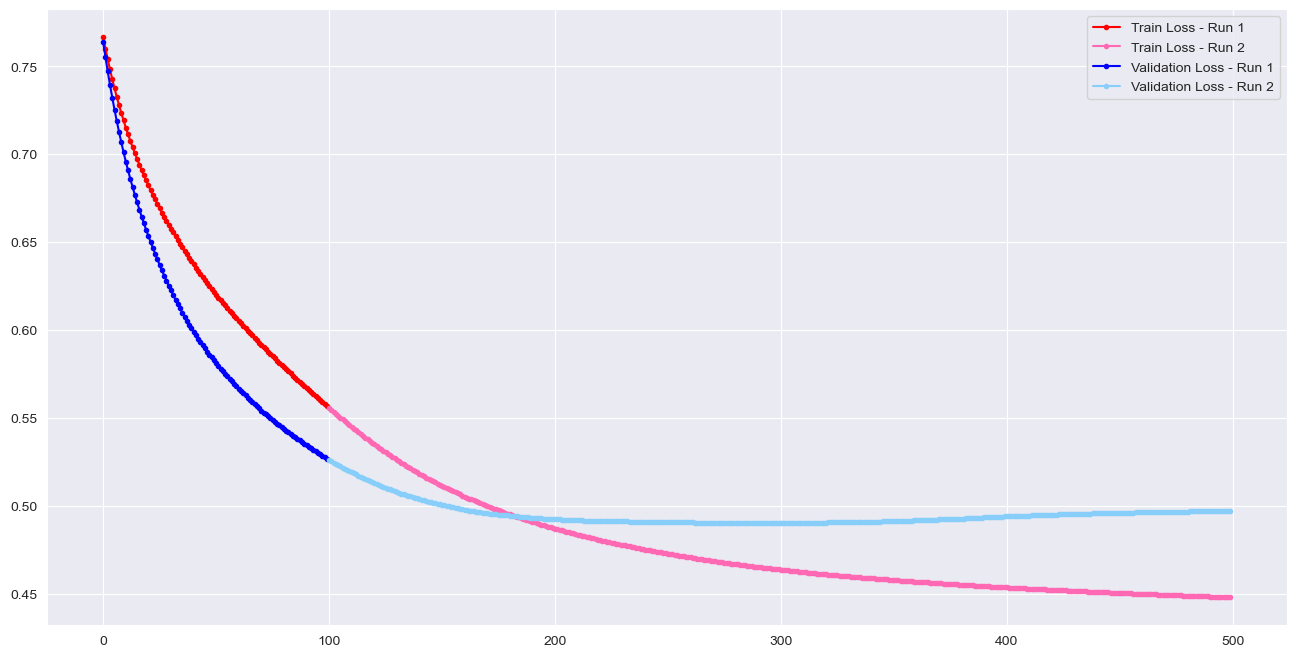

In [123]:
plt.close('all')
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()
plt.show()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

## <span style="color: green;">จงแสดงวิธีคำนวณจำนวนพารามิเตอร์ของโมเดลนี้ซึ่งมี 81 ตัว โดยให้แสดงที่มาของจำนวนพารามิเตอร์ในแต่ละเลเยอร์และจำนวนรวมทั้งหมด</span>
![](https://drive.google.com/thumbnail?id=1bv9DT2b5H3dFdEe0AJT6qXVHG9h88Esl&sz=w640)

วิธีคำนวณจำนวน Parameters ของ Model เป็นดังนี้

วิธีคำนวณจำนวน Parameters ของ Model เป็นดังนี้

dense
1. **Input Layer**: มี 8 features ดังนั้นไม่มีพารามิเตอร์ในเลเยอร์นี้
2. **Output Layer**: มี 8 Node และเชื่อมต่อกับ 8 features ของ Input Layer หมายความว่า
    - Weight = 8 ต่อ Node
    - Bias = 1 ต่อ Node
ดังนั้นจำนวน Parameters ของ dense ี้จะมีเท่ากับ (8+1) * 8 = **72**

dense_1
1. **Input Layer**: มี 8 features ดังนั้นไม่มีพารามิเตอร์ในเลเยอร์นี้
2. **Output Layer**: มี 1 Node และเชื่อมต่อกับ 8 Node ของ Dense แรก หมายความว่า
    - Weight = 8 ต่อ Node
    - Bias = 1 ต่อ Node
ดังนั้นจำนวน Parameters ของ dense_1 จะมีเท่ากับ (8+1) * 1 = **9**

จำนวน Parameters ทั้งหมดของโมเดลนี้จะเท่ากับ 72 + 9 = **81**

1. **Input Layer**: มี 8 features ดังนั้นไม่มีพารามิเตอร์ในเลเยอร์นี้## <span style="color: green;">เพิ่ม Code Cell เพื่อ</span>
* <span style="font-size:20px;">สร้างโมเดลที่มีเลเยอร์ hidden 2 ชั้น และแต่ละชั้นมี 6 โหนด</span>
* <span style="font-size:20px;">ปรับโค้ดให้สามารถรับอินพุตที่มีจำนวน feature ตามข้อมูลเทรนที่จะถูกส่งเข้ามา (ปราศจากการใช้ค่าคงที่ 8 ที่ถูกระบุอยู่ในโค้ด ณ ตอนนี้)</span>
* <span style="font-size:20px;">สำหรับเลเยอร์ hidden ให้ใช้ activation function เป็น "relu" และเลเยอร์ output เป็น "sigmoid"</span>
* <span style="font-size:20px;">ใช้ learning rate เท่ากับ 0.003 และเทรนด้วยจำนวน 250 epochs ส่วนสำหรับ Hyperparameter ที่เหลือให้ใช้ค่าคงเดิม</span>
* <span style="font-size:20px;">วาดกราฟของค่า loss และ accuracy ด้วยทั้งชุดข้อมูล train และ test (ดังตัวอย่างในรูปนี้)</span>
![Loss and Accuracy Graph](https://drive.google.com/thumbnail?id=1GuN0KQf64rGMa4oCY2upnbOTMzWaXmbT&sz=h360)
* <span style="font-size:20px;">วาดกราฟ ROC ของทั้งชุดข้อมูล train และ test พร้อมแสดงค่า AUC ของโมเดล</span>


In [109]:
model_2 = Sequential([
    Dense(6, input_shape=(8, ), activation="relu"),
    Dense(6, input_shape=(6, ), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [110]:
model_2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 6)              │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103 (412.00 B)

 Trainable params: 103 (412.00 B)

 Non-trainable params: 0 (0.00 B)

In [111]:
model_2_learning_rate = 0.003
model_2_epoch = 250

model_2.compile(optimizer=SGD(learning_rate=model_2_learning_rate), loss="binary_crossentropy", metrics=["accuracy"])

run_hist_2 = model_2.fit(X_train_norm, y_train, validation_split=0.1, epochs=model_2_epoch, batch_size=32)

Epoch 1/250
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6525 - loss: 0.6322 - val_accuracy: 0.6379 - val_loss: 0.6539
Epoch 2/250
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6558 - loss: 0.6300 - val_accuracy: 0.6379 - val_loss: 0.6514
Epoch 3/250
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6559 - loss: 0.6279 - val_accuracy: 0.6379 - val_loss: 0.6490
Epoch 4/250
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6608 - loss: 0.6259 - val_accuracy: 0.6379 - val_loss: 0.6467
Epoch 5/250
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6647 - loss: 0.6239 - val_accuracy: 0.6379 - val_loss: 0.6444
Epoch 6/250
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6643 - loss: 0.6221 - val_accuracy: 0.6552 - val_loss: 0.6423
Epoch 7/250
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6624 - loss: 0.6202 - val_accuracy: 0.6379 - val_loss: 0.6402
Epoch 8/250
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6602 - loss: 0.6185 - val_accuracy: 0.6552 - 

In [164]:
def plot_loss_accuracy(history):
    plt.close('all')

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    epochs = np.arange(1, len(val_loss) + 1)
    train_label = 'train'
    val_label = 'val'

#   Loss
    fig = plt.figure(figsize=(16, 7))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(epochs, train_loss, 'blue', label=train_label)
    ax.plot(epochs, val_loss, 'orange', label=val_label)
    ax.grid(True)
    ax.set(xlabel='epochs', ylabel='loss', title='Loss')
    ax.set_xticks([1] + list(ax.get_xticks()[ax.get_xticks() > 1]))
    ax.legend()

#   Accuracy
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(epochs, train_accuracy, 'blue', label=train_label)
    ax.plot(epochs, val_accuracy, 'orange', label=val_label)
    ax.grid(True)
    ax.set(xlabel='epochs', ylabel='accuracy', title='Accuracy')
    ax.set_xticks([1] + list(ax.get_xticks()[ax.get_xticks() > 1]))
    ax.legend()

    plt.show()

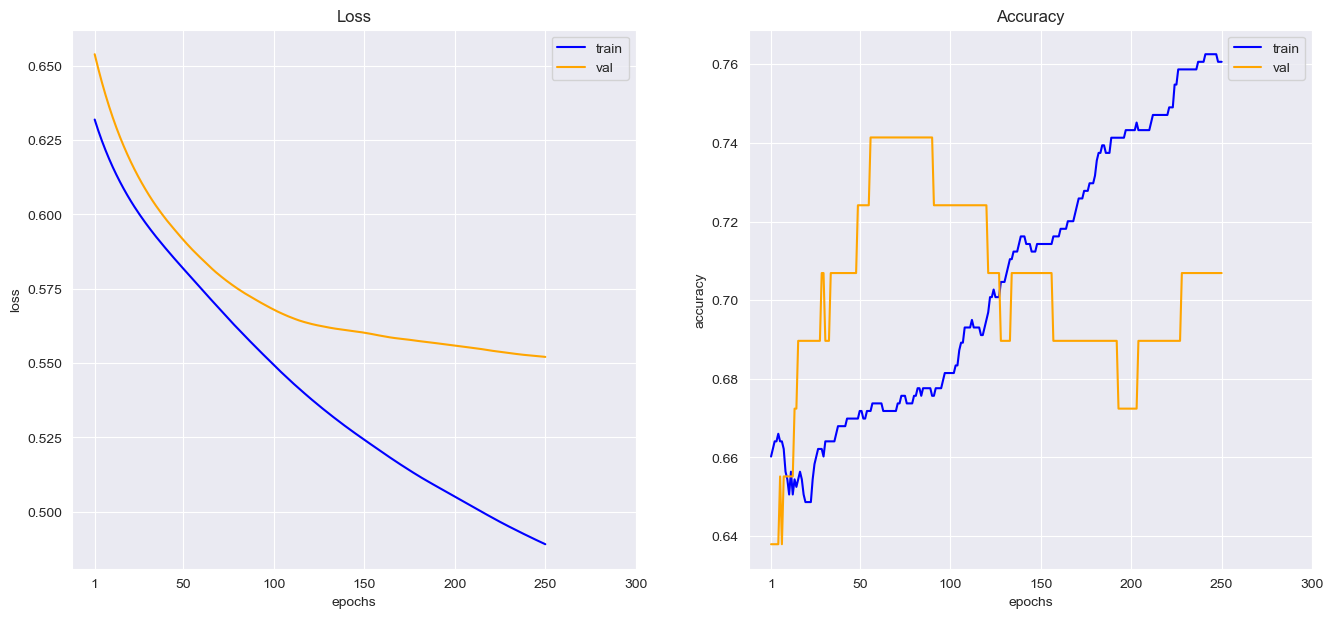

In [179]:
plot_loss_accuracy(run_hist_2.history)

In [159]:
def plot_roc_custom(model, p_score, x, y, title):
    y_pred_prob = model.predict(x)
    y_pred_class = (y_pred_prob >= p_score).astype('int32')
    print('{}: accuracy is {:.3f}, roc-auc is {:.3f}'.format(
        title,
        accuracy_score(y, y_pred_class),
        roc_auc_score(y, y_pred_prob))
    )
    plot_roc(y, y_pred_prob, title)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
NN 2 Train: accuracy is 0.755, roc-auc is 0.821


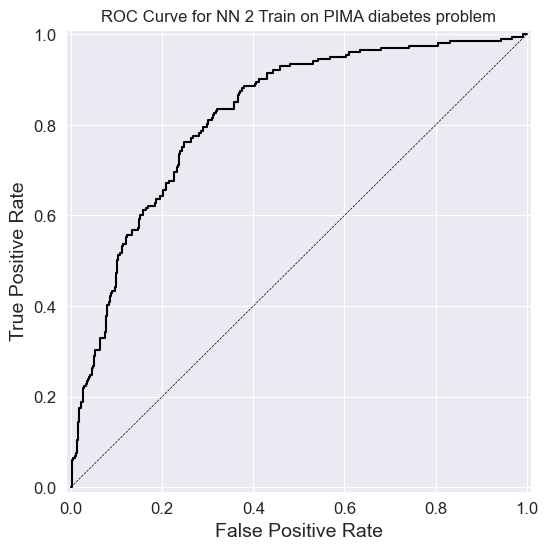

In [160]:
plot_roc_custom(model_2, 0.5, X_train_norm, y_train, 'NN 2 Train')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
NN 2 Test: accuracy is 0.708, roc-auc is 0.785


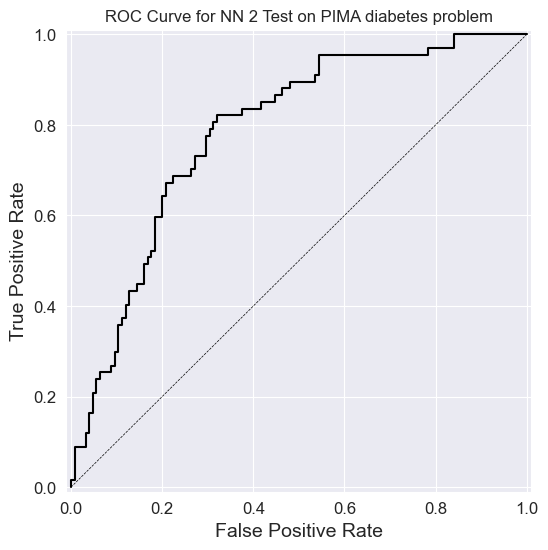

In [161]:
plot_roc_custom(model_2, 0.5, X_test_norm, y_test, 'NN 2 Test')

## <span style="color: green;">สร้างอีกโมเดลโดยปรับโครงสร้างที่เหมาะสมขึ้น รวมถึงการปรับค่า Hyperparameter ต่าง ๆ เพื่อให้โมเดลได้ประสิทธิภาพที่ดีขึ้นโดยพิจารณาจากค่า AUC</span>  
* <span style="font-size:20px;">ให้วาดกราฟของค่า loss และ accuracy ของโมเดลใหม่นี้ด้วย</span>
* <span style="font-size:20px;">วาดกราฟ ROC ของทั้งชุดข้อมูล train และ test พร้อมแสดงค่า AUC ของโมเดล</span>
* <span style="font-size:20px">อธิบายให้เห็นว่าผลลัพธ์ที่ได้จากโมเดลใหม่นั้นดีขึ้นจากโมเดลเดิม</span>

In [209]:
model_3 = Sequential([
    Dense(8, input_shape=(8, ), activation="relu", name='l1'),
    Dense(8, input_shape=(8, ), activation="relu", name='l2'),
    Dense(8, input_shape=(8, ), activation="relu", name='l3'),
    Dense(8, input_shape=(8, ), activation="relu", name='l4'),
    Dense(1, activation="sigmoid", name='lo')
], name='NN_3')

In [210]:
model_3.summary()

Model: "NN_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ l1 (Dense)                      │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2 (Dense)                      │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l3 (Dense)                      │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l4 (Dense)                      │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lo (Dense)                      │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

In [211]:
model_3_learning_rate = 0.005
model_3_epoch = 500
batch_size = 32

model_3.compile(optimizer=SGD(learning_rate=model_3_learning_rate), loss="binary_crossentropy", metrics=["accuracy"])
run_hist_3 = model_3.fit(X_train_norm, y_train, validation_split=0.1, epochs=model_3_epoch, batch_size=batch_size)

Epoch 1/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3825 - loss: 0.7055 - val_accuracy: 0.3448 - val_loss: 0.7086
Epoch 2/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4171 - loss: 0.6968 - val_accuracy: 0.3966 - val_loss: 0.6989
Epoch 3/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4665 - loss: 0.6896 - val_accuracy: 0.4310 - val_loss: 0.6906
Epoch 4/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4968 - loss: 0.6836 - val_accuracy: 0.5345 - val_loss: 0.6833
Epoch 5/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5551 - loss: 0.6784 - val_accuracy: 0.6034 - val_loss: 0.6768
Epoch 6/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6192 - loss: 0.6737 - val_accuracy: 0.6724 - val_loss: 0.6709
Epoch 7/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6497 - loss: 0.6695 - val_accuracy: 0.7241 - val_loss: 0.6657
Epoch 8/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6913 - loss: 0.6657 - val_accuracy: 0.7241 - 

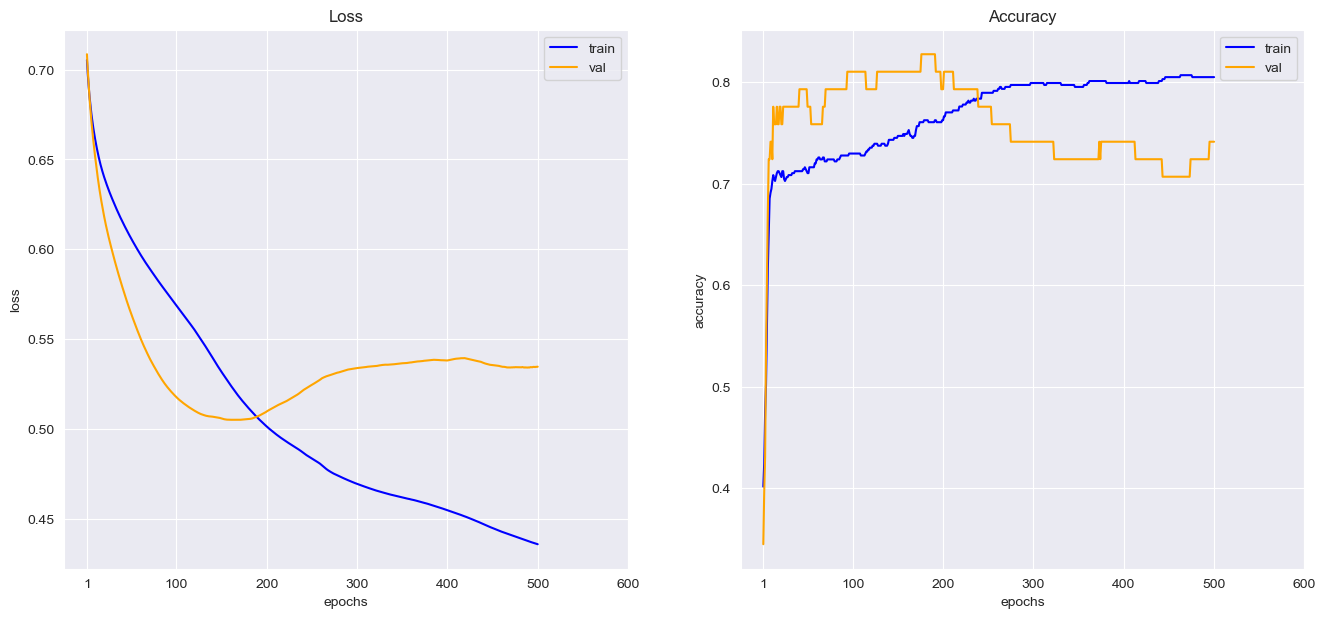

In [213]:
plot_loss_accuracy(run_hist_3.history)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
NN 3 Train: accuracy is 0.799, roc-auc is 0.859


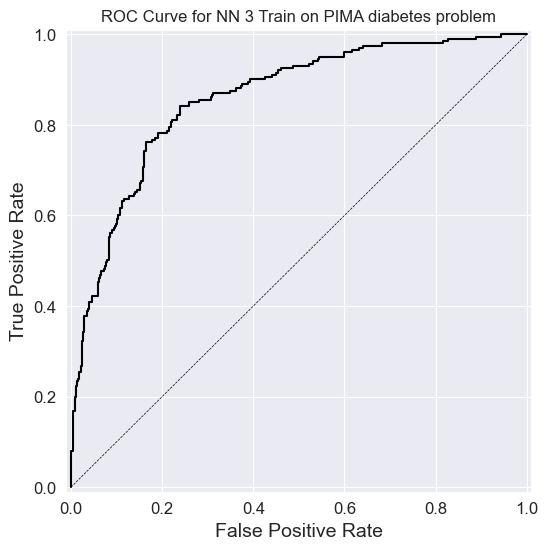

In [214]:
plot_roc_custom(model_3, 0.5, X_train_norm, y_train, 'NN 3 Train')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
NN 3 Test: accuracy is 0.755, roc-auc is 0.793


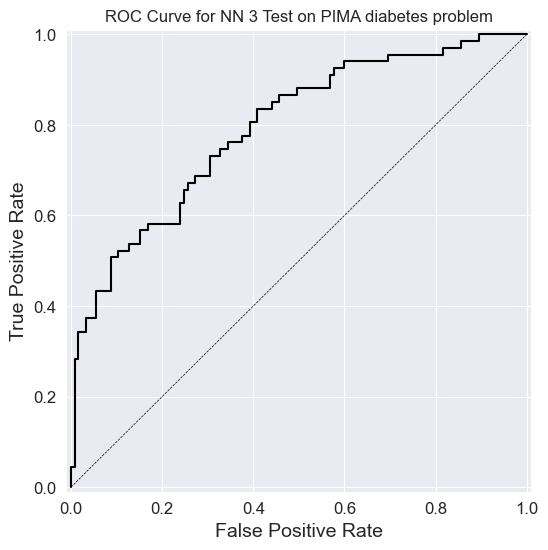

In [215]:
plot_roc_custom(model_3, 0.5, X_test_norm, y_test, 'NN 3 Test')